# 01. POI snapping, Denmark-wide
## Project: Bicycle node network loop analysis

This notebook snaps the POIs to the Denmark-wide network data which is assembled from the single study area networks created in 00.  
Please select `denmark` as the `study_area` in the `config.yml`.

Contact: Michael Szell (michael.szell@gmail.com)

Created: 2025-08-07  
Last modified: 2025-09-10

## To do

- [X] Rewrite snapping with momepy/geopandas

## Parameters

In [1]:
%run -i setup_parameters.py
debug = True  # Set to True for extra plots and verbosity

## Functions

In [2]:
%run -i functions.py

## Processing data

### Load data

In [3]:
# Merge graphs and degree distributions
Gnx = nx.empty_graph()
degreedistrib_pre = Counter()
for subarea in STUDY_AREA_COMBINED[STUDY_AREA]:
    with lzma.open(PATH[subarea]["data_out"] + "network_preprocessed0.xz", "rb") as f:
        G_new = pickle.load(f)
        Gnx = nx.disjoint_union(Gnx, G_new.to_networkx())
    with open(PATH[subarea]["data_out"] + "degreedistrib_pre.csv", "r") as csvfile:
        csvreader = csv.reader(csvfile)
        degrees = next(csvreader)
        counts = next(csvreader)
        for degree, count in zip(degrees, counts):
            degreedistrib_pre[int(degree)] += int(count)

# Load POIs
pois = load_pois()
if debug:
    print(pois.tail())

                            geometry    category
1208  POINT (645870.893 6261625.838)  attraction
1209  POINT (645153.577 6261902.125)  attraction
1210  POINT (646215.302 6262344.774)  attraction
1211  POINT (646350.415 6262438.782)  attraction
1212    POINT (646340.25 6263259.36)  attraction


Turn into gdf and initialize:

In [4]:
# https://docs.momepy.org/en/stable/user_guide/graph/convert.html
nodes, edges = momepy.nx_to_gdf(Gnx, points=True, lines=True)
nodes.set_crs(epsg=25832, inplace=True)
nodes_id = list(nodes.nodeID)
nodes_x = list(nodes.geometry.x)
nodes_y = list(nodes.geometry.y)
nodes_coords = list(zip(normalize_data(nodes_x), normalize_data(nodes_y)))

edges.set_crs(epsg=25832, inplace=True)

# Initialize
edges["has_water"] = False
edges["has_facility"] = False
edges["has_service"] = False
edges["has_attraction"] = False
edges["poi_diversity"] = 0

if debug:
    print(edges.head())

        weight  edge_id  max_slope  \
0  4070.941878        0   3.750957   
1  5059.992235        1   4.673647   
2  3526.484593        2   4.319620   
3  3894.576779        3   2.770777   
4  9627.531989        4   2.348074   

                                            geometry  _igraph_index  \
0  LINESTRING (664790.176 6231667.992, 664809.13 ...              0   
1  LINESTRING (661658.93 6234106.8, 661668.7 6234...              1   
2  LINESTRING (664790.176 6231667.992, 664790.75 ...              2   
3  LINESTRING (666896.12 6234528.37, 666899.6 623...              3   
4  LINESTRING (668758.8 6232075.84, 668772.57 623...              4   

   node_start  node_end  has_water  has_facility  has_service  has_attraction  \
0           0         1      False         False        False           False   
1           0         2      False         False        False           False   
2           0         3      False         False        False           False   
3           1       

/var/folders/q4/95x26cls17s1z694v56lw3hh0000gn/T/ipykernel_56315/1962991751.py:2: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes, edges = momepy.nx_to_gdf(Gnx, points=True, lines=True)


### Snap POIs

Snap POIs to network. POIs come in 3 categories:
- Facilities (water station, bicycle repair station, supermarket, etc.)
- Services (camping ground, hotel, gas station, etc.)
- Attractions (church, museum, beach, etc.)  

If any of these is within reach of a link, the link is assumed to provide water. Further, we define a link's POI diversity $Y \in \{0,1,2,3\}$ as the unique number of POI categories within reach. For simplicity, reach is defined with the same constant `SNAP_THRESHOLD` for all POI categories.

In [5]:
pois_snapped = snap_pois(pois, edges)
if debug:
    print(pois_snapped.head())

                         geometry  category  index_edge
0  POINT (643401.618 6240465.878)  facility        29.0
1   POINT (643275.762 6240635.51)  facility        29.0
2  POINT (643309.426 6240602.634)  facility        29.0
3  POINT (643308.975 6240603.155)  facility        29.0
4    POINT (642938.29 6240832.61)  facility        29.0


With the snapped POIs, update the POI attributes of all affected edges:

In [6]:
edges = update_poi_attributes(edges, pois_snapped)
if debug:
    print(edges.tail())

Update link attributes with snapped POIs:   0%|          | 0/965 [00:00<?, ?it/s]

         weight  edge_id  max_slope  \
84  7202.598197       82   7.453728   
85  8780.749138       83   7.187061   
86  1550.702744       86  10.002678   
87  2677.154402       87   6.794731   
88  3707.191975       88  16.113976   

                                             geometry  _igraph_index  \
84  LINESTRING (648435.41 6256862.86, 648438.64 62...             84   
85  LINESTRING (654734.815 6255358.67, 654732.79 6...             85   
86  LINESTRING (647428.34 6257639.3, 647429.69 625...             86   
87  LINESTRING (645997.72 6259249.94, 645998.98 62...             87   
88  LINESTRING (648212.46 6260445.92, 648192 62604...             88   

    node_start  node_end  has_water  has_facility  has_service  \
84          53        56       True          True        False   
85          54        57       True          True         True   
86          55        56      False         False        False   
87          55        58       True          True        False   
88

gdf to nx to igraph 😅:

In [7]:
G = gdf_to_igraph(edges)
if debug:
    print(G.summary())

IGRAPH UNW- 59 89 -- 
+ attr: name (v), x (v), y (v), edge_id (e), geometry (e), has_attraction (e), has_facility (e), has_service (e), has_water (e), max_slope (e), node_end (e), node_start (e), poi_diversity (e), weight (e)


In [8]:
if debug:  # Just some code needed for the plots below
    Gnx = momepy.gdf_to_nx(
        edges, approach="primal", integer_labels=True
    )  # Update Gnx to get the same node ids as G, for plotting
    nodes, edges = momepy.nx_to_gdf(Gnx, points=True, lines=True)
    nodes.set_crs(epsg=25832, inplace=True)
    nodes_id = list(nodes.nodeID)
    nodes_x = list(nodes.geometry.x)
    nodes_y = list(nodes.geometry.y)
    nodes_coords = list(zip(normalize_data(nodes_x), normalize_data(nodes_y)))

#### Plot POI diversity

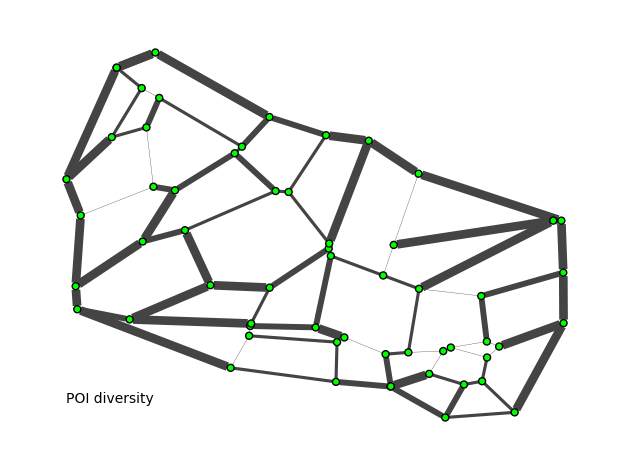

In [9]:
if debug:
    edge_widths = []
    for e in G.es:
        edge_widths.append((e["poi_diversity"] * 2) + 0.25)

    fig = plot_check(
        G,
        nodes_id,
        nodes_coords,
        vertex_size=get_vertex_size_constant(G.vcount()),
        edge_width=edge_widths,
    )
    plt.text(0, 0.04, "POI diversity")
    plt.tight_layout()

#### Plot water links

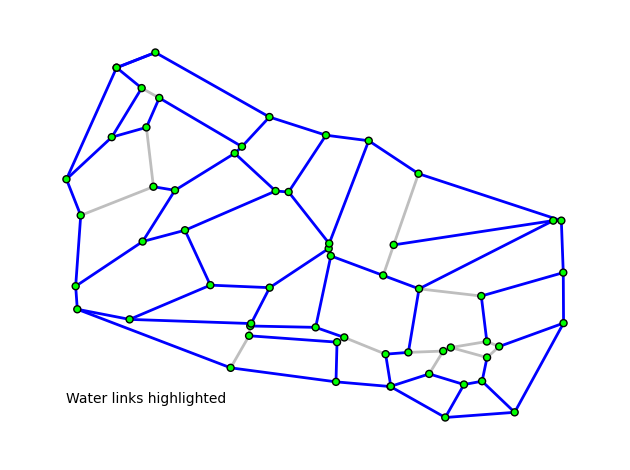

In [10]:
if debug:
    edge_colors = []
    for e in G.es:
        if e["has_water"]:
            edge_colors.append("blue")
        else:
            edge_colors.append("grey")

    fig = plot_check(
        G,
        nodes_id,
        nodes_coords,
        vertex_size=get_vertex_size_constant(G.vcount()),
        edge_color=edge_colors,
    )
    plt.text(0, 0.04, "Water links highlighted")
    plt.tight_layout()

#### Plot max slopes

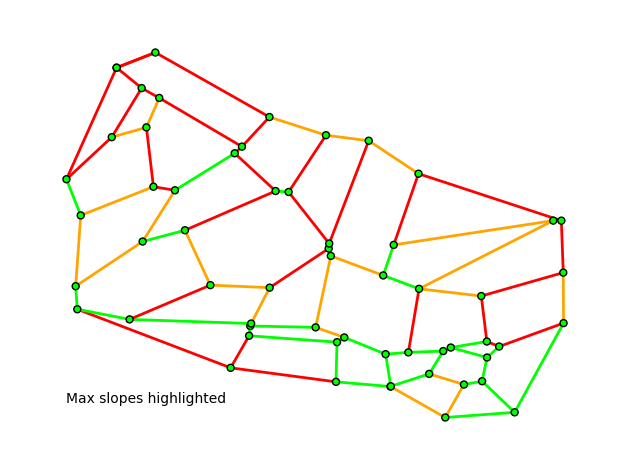

In [11]:
if debug:
    edge_colors = []
    for e in G.es:
        if e["max_slope"] < 4:
            edge_colors.append("green")
        elif e["max_slope"] < 6:
            edge_colors.append("orange")
        else:
            edge_colors.append("red")

    fig = plot_check(
        G,
        nodes_id,
        nodes_coords,
        vertex_size=get_vertex_size_constant(G.vcount()),
        edge_color=edge_colors,
    )
    plt.text(0, 0.04, "Max slopes highlighted")
    plt.tight_layout()

## Save preprocessed network data

In [12]:
# Save merged degree distribution before preprocessing
degreedistrib_to_csv(degreedistrib_pre, PATH["data_out"] + "degreedistrib_pre.csv")

# Save merged degree distribution after preprocessing
degreedistrib_to_csv(Counter(G.degree()), PATH["data_out"] + "degreedistrib_post.csv")

In [13]:
with lzma.open(PATH["data_out"] + "network_preprocessed.xz", "wb") as f:
    pickle.dump(G, f)